# Positioning project

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import scipy.fftpack
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline


In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
def statfeatureextract(data_sliced, num_sample):
    order = 5
    cutoff = 20
    fs = num_sample/10
    lowcut = 0.1
    highcut = 20
    if flag_lowpass == 1:
        x_filtered = butter_lowpass_filter(data_sliced.x, cutoff, fs, order)
        y_filtered = butter_lowpass_filter(data_sliced.y, cutoff, fs, order)
        z_filtered = butter_lowpass_filter(data_sliced.z, cutoff, fs, order)
    else:
        x_filtered = butter_bandpass_filter(data_sliced.x, lowcut, highcut, fs, order)
        y_filtered = butter_bandpass_filter(data_sliced.y, lowcut, highcut, fs, order)
        z_filtered = butter_bandpass_filter(data_sliced.z, lowcut, highcut, fs, order)
    x_mean = x_filtered.mean()
    x_var = x_filtered.var()
    y_mean = y_filtered.mean()
    y_var = y_filtered.var()
    z_mean = z_filtered.mean()
    z_var = z_filtered.var()
    return {"num_sample": int(data_sliced.shape[0]),"x_mean":x_mean, "x_var":x_var , "y_mean": y_mean, 
            "y_var": y_var, "z_mean": z_mean, "z_var": z_var}

def createstatfeature(data, activity):
#   remove outliner
    data.loc[data.x > 30, "x"] = 30
    data.loc[data.y > 30, "y"] = 30
    data.loc[data.z > 30, "z"] = 30
    data.loc[data.x < -30, "x"] = -30
    data.loc[data.y < -30, "y"] = -30
    data.loc[data.z < -30, "z"] = -30
    
    time_diff = 10000
    samplesper10sec = []
    statfeature = pd.DataFrame([])
    count = 0
    # if time index is a constant, we'll assume it samples at 250 Hz
    if data.time[0] == data.time[1]:
        data.time = np.arange(data.time[0], data.time[0] + 4*len(data.time) ,4)
    # slice data into 10 second period and extract statistical features.
    while len(data.time) > 1500:
        num_sample = np.sum(np.less_equal(data.loc[:, 'time'], 
                                          data.time[0]+time_diff))
        samplesper10sec.append(num_sample)
        data_sliced = data.loc[range(num_sample),:]
        statfeature = statfeature.append(statfeatureextract(data_sliced, num_sample), ignore_index=True)
        data.drop(range(num_sample), inplace = True)
        data.reset_index(drop=True, inplace = True)
        
    # add label to extracted features dataframe. 
    labeldict = {'laying_down':1, 'sitting':2, 'standing':3, 'walking':4}
    num_period = len(statfeature.x_mean)
    labels = pd.DataFrame({'activity_name': [activity]*num_period, 
                           'activity_label': [labeldict[activity]]*num_period})
    # # statfeature.
    result = pd.concat([statfeature, labels], axis = 1)
    return result

In [4]:
headername = ["time", "x", "y", "z", "ind", "label"]
flag_lowpass = 1
data = pd.read_csv('data new/train/layingdown/1_android.sensor.accelerometer.data.csv',names = headername)
df1 = createstatfeature(data, "laying_down")
data = pd.read_csv('data new/train/sitting/1_android.sensor.accelerometer.data.csv',names = headername)
df2 = createstatfeature(data, "sitting")
data = pd.read_csv('data new/train/standing/1_android.sensor.accelerometer.data.csv',names = headername)
df3 = createstatfeature(data, "standing")
data = pd.read_csv('data new/train/walking/1_android.sensor.accelerometer.data.csv',names = headername)
df4 = createstatfeature(data, "walking")

In [5]:
data = pd.concat([df1, df2, df3, df4], ignore_index=True )
data.head()

,num_sample,x_mean,x_var,y_mean,y_var,z_mean,z_var,activity_label,activity_name
0,2527.0,7.925670,1.541568,3.672065,8.216504,3.736582,2.086954,1,laying_down
1,2546.0,8.479127,0.186375,2.190249,0.068036,4.986966,0.132046,1,laying_down
2,2541.0,8.514861,0.176351,2.970144,0.077441,4.501829,0.082359,1,laying_down
3,2537.0,8.650775,0.191904,2.928703,0.162285,4.280782,0.143450,1,laying_down
4,2541.0,8.684892,0.175523,3.234331,0.097473,4.023345,0.043487,1,laying_down


In [6]:
x = data[['num_sample', 'x_mean', 'x_var', 'y_mean', 'y_var', 'z_mean', 'z_var']]
y = data[['activity_label']]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)


c:\users\shoun\anaconda2\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\shoun\anaconda2\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


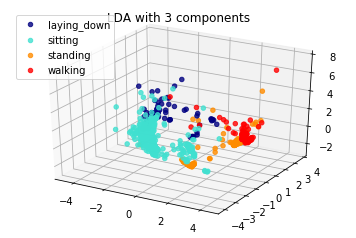

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lw = 1
colors = ['navy', 'turquoise', 'darkorange','red']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lda = LinearDiscriminantAnalysis(n_components=3)
x_lda = lda.fit_transform(x,y)
for color, i, target_name in zip(colors, [1, 2, 3, 4], data.activity_name.unique()):
    ax.scatter(x_lda[y.activity_label == i, 0], x_lda[y.activity_label == i, 1], 
                x_lda[y.activity_label == i, 2], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA with 3 components')

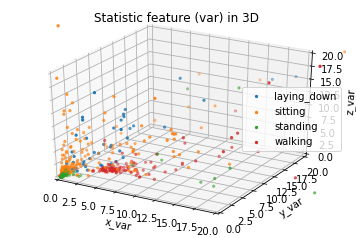

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for color, i, target_name in zip(colors, [1, 2, 3, 4], data.activity_name.unique()):
    xs = x.loc[y.activity_label == i, 'x_var']
    ys = x.loc[y.activity_label == i, 'y_var']
    zs = x.loc[y.activity_label == i, 'z_var']
    ax.scatter(xs, ys, zs, s = 5, label=target_name)
    
ax.set_xlabel('x_var');ax.set_ylabel('y_var');ax.set_zlabel('z_var')
ax.set_xbound(0,20);ax.set_ybound(0,20);ax.set_zbound(0,20)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("Statistic feature (var) in 3D ")

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(x_train, y_train)
knn_clf.score(x_test, y_test)
accu = np.mean(cross_val_score(knn_clf, x, y.activity_label, cv=10))
print("average accuracy for knn(k=5) is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, knn_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

average accuracy for knn(k=5) is 0.92226


c:\users\shoun\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Predicted,1,2,3,4,All
True,,,,,
1,34,3,0,0,37
2,8,89,0,0,97
3,0,0,62,1,63
4,0,0,1,33,34
All,42,92,63,34,231


In [10]:
## decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(x_train, y_train.activity_label)
accu = np.mean(cross_val_score(dt_clf, x, y.activity_label, cv=10))
print("average accuracy for decisiontree is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, dt_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

average accuracy for decisiontree is 0.8941


Predicted,1,2,3,4,All
True,,,,,
1,35,2,0,0,37
2,5,92,0,0,97
3,0,0,62,1,63
4,0,0,1,33,34
All,40,94,63,34,231


In [13]:
#Header 1M/N?MM
## yooo